# Case 2 Assignment

### Authors
- Katja (student.no.)
- Lukas (student no.)
- Mark (student no.)
- Sebastian (student no.)

### High level methodology

1. Phase-Specific Clustering:
- Why Separate Phases: By clustering each phase separately (pre-puzzle, puzzle, and post-puzzle), we can directly assess the impact of each experimental condition on physiological responses. This separation allows us to analyze how participants' responses evolve from a resting state to a stress-induced state and then to recovery.

- Execution: We will perform clustering on each phase's data independently, then track the cluster assignments of each participant across phases.

2. Comparing Clusters Across Phases: 

- Consistency Analysis: After clustering, the key analysis is to see whether participants who are grouped together in one phase remain together in subsequent phases. This would indicate consistency in physiological responses among those participants.

- Method: We could use contingency tables or cross-tabulations to compare cluster memberships. (or flow charts) For a more quantitative measure, metrics we will use  Adjusted Rand Index (ARI) which will help quantify the similarity between two clusterings.

3. Integration with Self-reported Emotional Scores:

- Purpose: Including emotional scores might provide additional insights into whether the physiological clustering correlates with participants' subjective experience of the tasks.

- Analysis: Correlate cluster membership with average scores of emotions like frustration, alertness, etc., to validate or explore the physiological findings.

## Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK
from sklearn.metrics import adjusted_rand_score
import plotly.graph_objects as go


## Load Data

In [4]:
data = pd.read_csv("data/HR_data.csv")
data.head()

,Unnamed: 0,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,...,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,0,78.663878,76.70,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.7300,...,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,1,76.540732,76.61,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.3600,...,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0
2,2,78.173563,77.92,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.6300,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
3,3,83.073688,83.88,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.4650,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
4,4,72.281250,72.91,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.3725,...,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0


## Preprocessing

In [5]:
# Find the rows with missing values
missing = data.isnull().sum()
missing[missing > 0]

# Impute rows with missing values for the column EDA_TD_P_RT and EDA_TD_P_ReT, since there is only two of them
data["EDA_TD_P_RT"] = data["EDA_TD_P_RT"].fillna(data["EDA_TD_P_RT"].mean())
data["EDA_TD_P_ReT"] = data["EDA_TD_P_ReT"].fillna(data["EDA_TD_P_ReT"].mean())


# Drop first column
data = data.drop(columns=["Unnamed: 0"])

# Cast Round to int
data["Round"] = data["Round"].apply(lambda x: int(x.split("_")[1]))

# Cast Cohort to int
data["Cohort"] = data["Cohort"].apply(lambda x: int(x.split("_")[1]))

# Cast phase to int
data["Phase"] = data["Phase"].apply(lambda x: int(x.split("e")[1]))

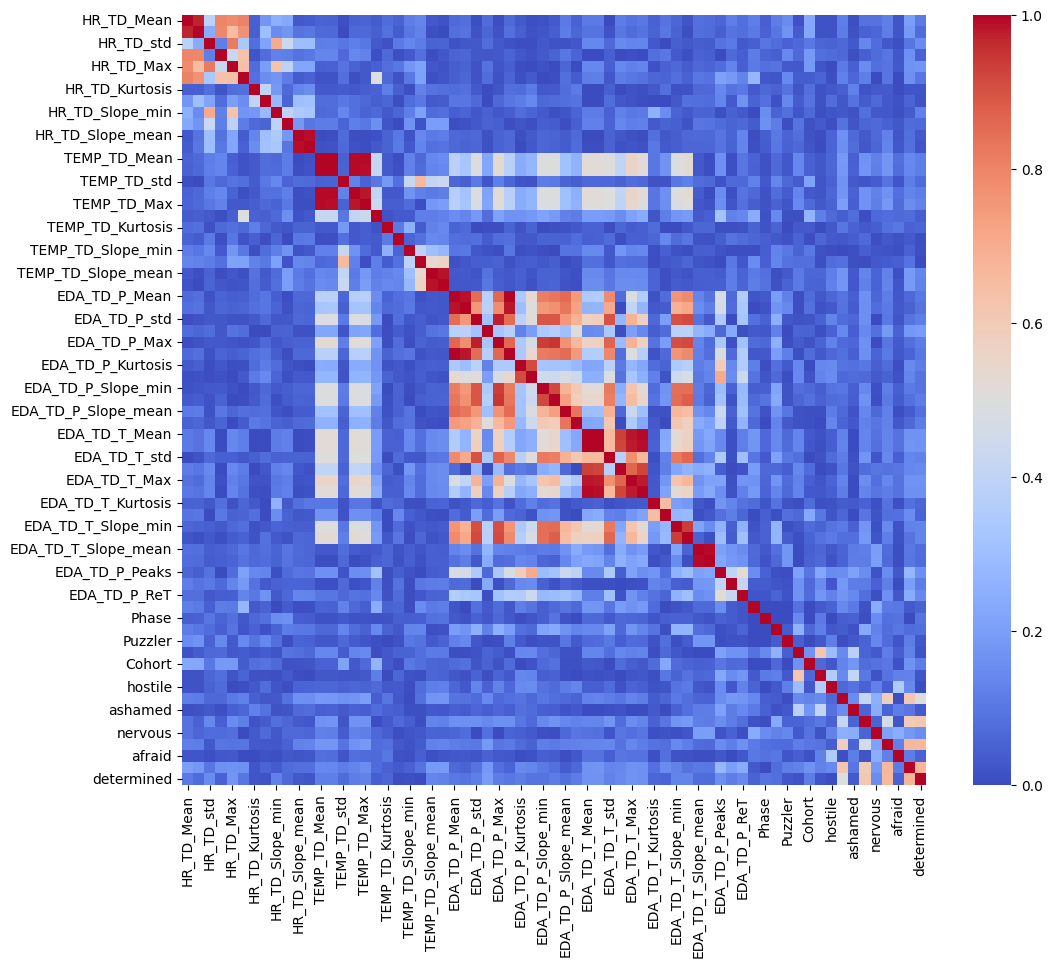

In [6]:
# Do correlation matrix and exclude highly correlated features
correlation = data.corr()
correlation = correlation.abs()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.show()


In [7]:
# Print correlation pairs that have a correlation higher than 0.9
correlation_pairs = correlation.unstack()
correlation_pairs = correlation_pairs[correlation_pairs > 0.9]
correlation_pairs = correlation_pairs[correlation_pairs < 1]
correlation_pairs = correlation_pairs.drop_duplicates()

for pair in correlation_pairs.index:
    print(pair, correlation_pairs[pair])

('HR_TD_Mean', 'HR_TD_Median') 0.9711090179326857
('HR_TD_Slope_mean', 'HR_TD_Slope') 0.988483580720514
('TEMP_TD_Mean', 'TEMP_TD_Median') 0.999642064136751
('TEMP_TD_Mean', 'TEMP_TD_Min') 0.9957182390665097
('TEMP_TD_Mean', 'TEMP_TD_Max') 0.9937968166938452
('TEMP_TD_Median', 'TEMP_TD_Min') 0.9950233585796113
('TEMP_TD_Median', 'TEMP_TD_Max') 0.9921187756697973
('TEMP_TD_Min', 'TEMP_TD_Max') 0.9823554279207789
('TEMP_TD_Slope_mean', 'TEMP_TD_Slope') 0.9862403216638368
('EDA_TD_P_Mean', 'EDA_TD_P_Median') 0.9849312638552072
('EDA_TD_P_Mean', 'EDA_TD_P_AUC') 0.9986950689710232
('EDA_TD_P_Median', 'EDA_TD_P_AUC') 0.9830782502328376
('EDA_TD_P_std', 'EDA_TD_P_Max') 0.9729404018401826
('EDA_TD_P_std', 'EDA_TD_T_Slope_min') 0.9033461816036368
('EDA_TD_P_std', 'EDA_TD_T_Slope_max') 0.915138069800837
('EDA_TD_P_Max', 'EDA_TD_P_Slope_min') 0.935288449231538
('EDA_TD_P_Max', 'EDA_TD_P_Slope_max') 0.9483760188161984
('EDA_TD_P_Max', 'EDA_TD_T_Slope_min') 0.9073653754199978
('EDA_TD_P_Max', 'EDA_

In [8]:
print(data.columns)

Index(['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT', 'Round', 

In [9]:
# Not including highly correlated features (e.g. mean and median) and only focusing on physiological features

features = ['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_std',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_std',
       'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT'
]

In [36]:

features = ['HR_TD_Mean', 'TEMP_TD_Mean']

In [37]:
X_phase1_r1 = data[(data["Phase"] == 1) & (data["Round"].isin([1]))][features]
X_phase1_r2 = data[(data["Phase"] == 1) & (data["Round"].isin([2]))][features]
X_phase1_r3 = data[(data["Phase"] == 1) & (data["Round"].isin([3]))][features]
X_phase1_r4 = data[(data["Phase"] == 1) & (data["Round"].isin([4]))][features]
X_phase2_r1 = data[(data["Phase"] == 2) & (data["Round"].isin([1]))][features]
X_phase2_r2 = data[(data["Phase"] == 2) & (data["Round"].isin([2]))][features]
X_phase2_r3 = data[(data["Phase"] == 2) & (data["Round"].isin([3]))][features]
X_phase2_r4 = data[(data["Phase"] == 2) & (data["Round"].isin([4]))][features]
X_phase3_r1 = data[(data["Phase"] == 3) & (data["Round"].isin([1]))][features]
X_phase3_r2 = data[(data["Phase"] == 3) & (data["Round"].isin([2]))][features]
X_phase3_r3 = data[(data["Phase"] == 3) & (data["Round"].isin([3]))][features]
X_phase3_r4 = data[(data["Phase"] == 3) & (data["Round"].isin([4]))][features]




KeyError: 'Phase'

# TODO:
- [X] Find the best number of clusters for each phase separately (using the elbow method, silhouette score, gap statistic)
- [X] Use Rand index to compare the clustering results between the phases to check if participants are clustered similarly in all phases
- [ ] Use contingency tables or cross-tabulations to compare cluster memberships. (or flow charts) 

- [ ] Integration with Self-reported Emotional Scores:
- [ ] Analyse clusters with average scores of emotions like frustration, alertness, etc., to validate or explore the physiological findings.
- [ ] Analyse clusters with mean physiological features to understand the physiological differences between clusters

Elbow method shows that cluster of K=6 is the best, but it's not clear

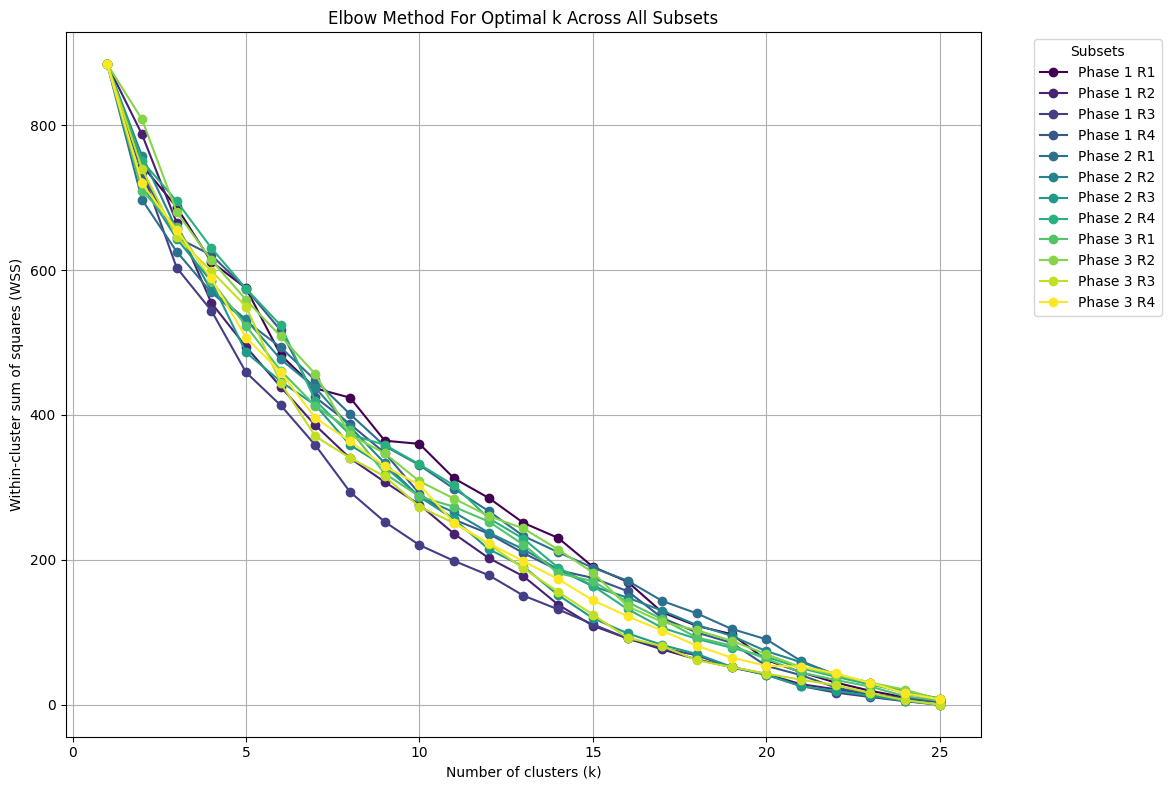

In [30]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define the list of all your data subsets
data_subsets = [
    X_phase1_r1, X_phase1_r2, X_phase1_r3, X_phase1_r4,
    X_phase2_r1, X_phase2_r2, X_phase2_r3, X_phase2_r4,
    X_phase3_r1, X_phase3_r2, X_phase3_r3, X_phase3_r4
]

# Names for labeling in the plot
subset_names = [
    'Phase 1 R1', 'Phase 1 R2', 'Phase 1 R3', 'Phase 1 R4',
    'Phase 2 R1', 'Phase 2 R2', 'Phase 2 R3', 'Phase 2 R4',
    'Phase 3 R1', 'Phase 3 R2', 'Phase 3 R3', 'Phase 3 R4'
]

# Define a function to calculate WSS for a range of k values
def calculate_wss(data):
    wss = []
    for k in range(1, 26):
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(data)
        wss.append(kmeans.inertia_)
    return wss

# Prepare the figure for plotting
plt.figure(figsize=(14, 8))

# Colors for each line
colors = plt.cm.viridis(np.linspace(0, 1, len(data_subsets)))

# Calculate and plot WSS for each subset
for i, data_subset in enumerate(data_subsets):
    # Scale the data subset
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_subset)
    
    # Calculate WSS
    wss = calculate_wss(scaled_data)
    
    # Plot WSS
    plt.plot(range(1, 26), wss, marker='o', linestyle='-', color=colors[i], label=subset_names[i])

# Add plot details
plt.title('Elbow Method For Optimal k Across All Subsets')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WSS)')
plt.legend(title='Subsets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0,0,0.85,1])  # Adjust layout to make room for the legend

plt.show()


Silhoutte scores for the different phases:

Note that all the silhouette scores are quite poor so we can't conclude anything from it.

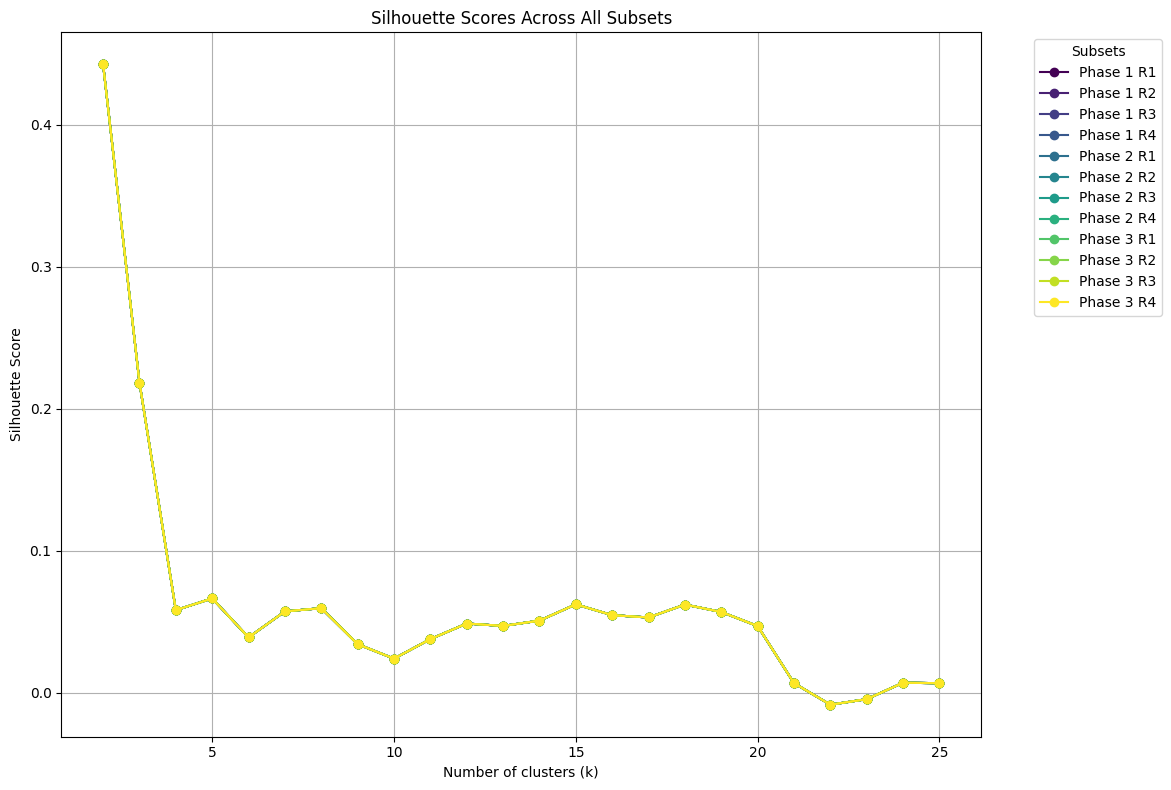

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



# Range of k values to try
k_values = range(2, 26)

# Define a function to calculate silhouette scores for a range of k values
def calculate_silhouette_scores(data):
    scores = []
    for k in k_values:
        # Check if dataset has at least k samples
        if len(data) >= k:
            kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(data)
            score = silhouette_score(data, kmeans.labels_)
            scores.append(score)
        else:
            scores.append(None)  # Append None if not enough samples for k clusters
    return scores

# Prepare the figure for plotting
plt.figure(figsize=(14, 8))

# Colors for each line
colors = plt.cm.viridis(np.linspace(0, 1, len(data_subsets)))

# Calculate and plot silhouette scores for each subset
for i, data_subset in enumerate(data_subsets):
    
    # Calculate silhouette scores
    scores = calculate_silhouette_scores(scaled_data)
    
    # Plot silhouette scores
    plt.plot([k for k in k_values if scores[k-2] is not None],
             [score for score in scores if score is not None],
             marker='o', linestyle='-', color=colors[i], label=subset_names[i])

# Add plot details
plt.title('Silhouette Scores Across All Subsets')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend(title='Subsets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0,0,0.85,1])  # Adjust layout to make room for the legend

plt.show()


Gap statistic:

Optimal clusters for Phase 1 R1: 26
Optimal clusters for Phase 1 R2: 26
Optimal clusters for Phase 1 R3: 26
Optimal clusters for Phase 1 R4: 26
Optimal clusters for Phase 2 R1: 26
Optimal clusters for Phase 2 R2: 26
Optimal clusters for Phase 2 R3: 26
Optimal clusters for Phase 2 R4: 26
Optimal clusters for Phase 3 R1: 26
Optimal clusters for Phase 3 R2: 26
Optimal clusters for Phase 3 R3: 26
Optimal clusters for Phase 3 R4: 26


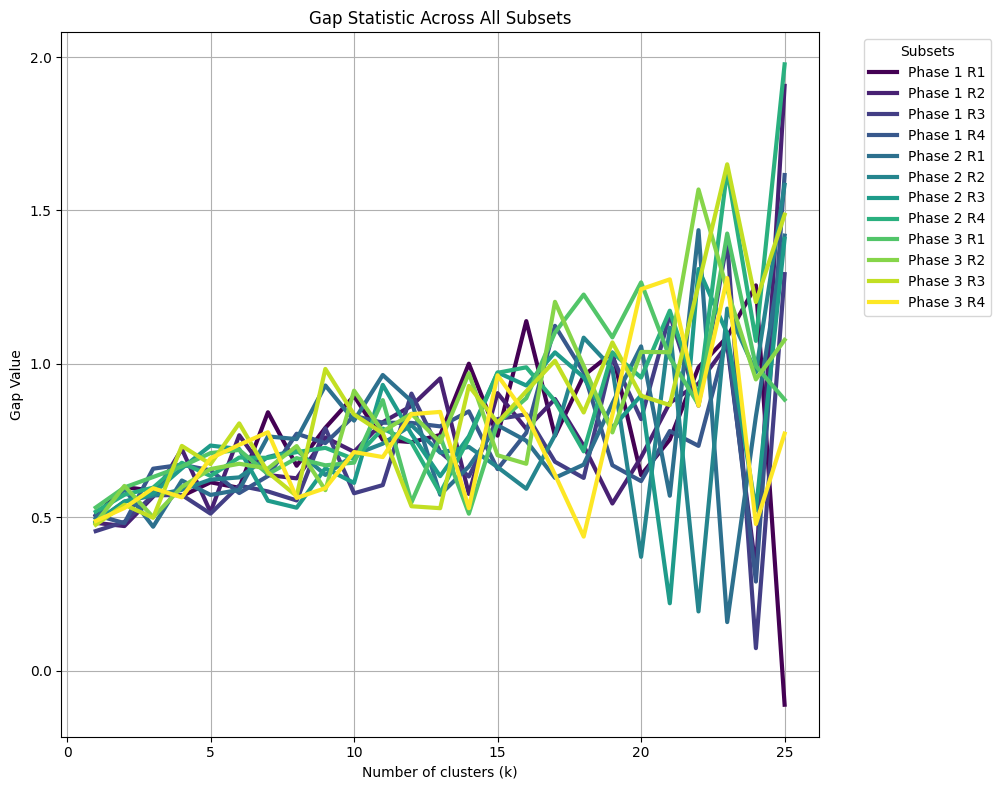

In [32]:
# Define a function to calculate gap statistic for a data subset
def compute_gap_statistic(data, max_k, title, plot_color):
    optimalK = OptimalK(n_jobs=-1, parallel_backend='joblib')
    n_clusters = optimalK(data, cluster_array=np.arange(1, max_k+1))
    print(f'Optimal clusters for {title}: {n_clusters}')
    plt.plot(optimalK.gap_df['n_clusters'], optimalK.gap_df['gap_value'], linewidth=3, label=title, color=plot_color)

# Max k value
max_k = 26

# Prepare the figure for plotting
plt.figure(figsize=(12, 8))

# Colors for each line
colors = plt.cm.viridis(np.linspace(0, 1, len(data_subsets)))

# Calculate and plot gap statistic for each subset
for i, data_subset in enumerate(data_subsets):
    # Scale the data subset
    
    # Calculate and plot gap statistic
    compute_gap_statistic(scaled_data, max_k, subset_names[i], colors[i])

# Add plot details
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Value')
plt.title('Gap Statistic Across All Subsets')
plt.legend(title='Subsets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0,0,0.85,1])  # Adjust layout to make room for the legend

plt.show()


Rand Index to compare clusterings (Using k from Gap statistic):

In [35]:

# Define the list of data subsets grouped by phase and round
data_subsets = {
    'Phase 1 Round 1': X_phase1_r1, 'Phase 1 Round 2': X_phase1_r2,
    'Phase 1 Round 3': X_phase1_r3, 'Phase 1 Round 4': X_phase1_r4,
    'Phase 2 Round 1': X_phase2_r1, 'Phase 2 Round 2': X_phase2_r2,
    'Phase 2 Round 3': X_phase2_r3, 'Phase 2 Round 4': X_phase2_r4,
    'Phase 3 Round 1': X_phase3_r1, 'Phase 3 Round 2': X_phase3_r2,
    'Phase 3 Round 3': X_phase3_r3, 'Phase 3 Round 4': X_phase3_r4
}

# Number of clusters
n_clusters = 10

# Initialize dict to hold KMeans models and labels for each subset
kmeans_models = {}
labels = {}

# Function to perform scaling and clustering
def cluster_data(key, data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    kmeans = KMeans(n_init='auto', n_clusters=n_clusters, random_state=0).fit(scaled_data)
    kmeans_models[key] = kmeans
    labels[key] = kmeans.labels_
    print(labels[key])

# Cluster each subset
for key, data in data_subsets.items():
    cluster_data(key, data)

# Function to calculate and print ARI between two phases and rounds
def calculate_and_print_ari(key1, key2):
    ari = adjusted_rand_score(labels[key1], labels[key2])
    print(f"Adjusted Rand Index between {key1} and {key2}: {ari}")

# Calculate ARIs for each round across all phase combinations
for round_num in range(1, 5):
    phase_keys = [f'Phase {i} Round {round_num}' for i in range(1, 4)]
    calculate_and_print_ari(phase_keys[0], phase_keys[1])
    calculate_and_print_ari(phase_keys[0], phase_keys[2])
    calculate_and_print_ari(phase_keys[1], phase_keys[2])


[9 2 7 2 2 3 0 9 9 5 7 9 0 6 7 3 7 1 4 8 7 3 7 2 2 7]
[2 4 8 5 9 5 5 4 1 4 4 5 0 5 7 5 5 5 6 3 5 1 1 5 4 1]
[0 0 8 0 5 9 2 0 2 0 5 2 0 8 6 3 6 3 1 7 0 0 4 0 0 4]
[6 6 6 6 8 2 6 6 2 5 9 6 0 6 3 3 3 3 1 3 7 2 4 6 6 5]
[8 2 7 7 5 5 5 4 9 4 2 5 0 8 3 3 3 1 6 3 5 7 8 7 2 4]
[3 9 9 1 7 3 9 3 1 5 9 0 0 7 8 6 4 6 2 8 3 1 0 3 7 4]
[7 2 8 9 9 7 0 7 7 0 6 7 0 7 3 3 3 4 1 4 0 7 3 0 2 5]
[6 4 4 9 1 8 4 4 6 4 1 6 0 6 8 8 8 2 7 3 1 6 5 8 6 6]
[9 8 0 9 9 9 9 9 6 0 7 7 0 0 2 2 2 1 2 5 5 3 4 5 5 4]
[0 0 9 0 5 0 3 0 3 0 4 8 0 9 6 7 0 1 2 5 0 7 7 0 0 7]
[6 6 8 9 4 4 1 6 4 6 3 6 0 1 4 4 4 4 2 7 1 1 5 1 0 5]
[0 0 2 7 5 7 0 0 9 0 0 7 0 0 6 7 7 4 1 5 8 8 3 8 0 7]
Adjusted Rand Index between Phase 1 Round 1 and Phase 2 Round 1: -0.028382395244031067
Adjusted Rand Index between Phase 1 Round 1 and Phase 3 Round 1: 0.017407237746220796
Adjusted Rand Index between Phase 2 Round 1 and Phase 3 Round 1: 0.08973029045643154
Adjusted Rand Index between Phase 1 Round 2 and Phase 2 Round 2: 0.018973695558430356
Adjusted

They all have really bad rand scores

Flow charts:

In [15]:

data = {
    'Phase 1': labels_phase1,
    'Phase 2': labels_phase2,
    'Phase 3': labels_phase3
}

df = pd.DataFrame(data)

# Create a contingency table for Phase 1 and Phase 2
contingency_table_1_2 = pd.crosstab(df['Phase 1'], df['Phase 2'])
print("Contingency Table between Phase 1 and Phase 2:")
print(contingency_table_1_2)

# Create a contingency table for Phase 1 and Phase 3
contingency_table_1_3 = pd.crosstab(df['Phase 1'], df['Phase 3'])
print("Contingency Table between Phase 1 and Phase 3:")
print(contingency_table_1_3)

# Create a contingency table for Phase 2 and Phase 3
contingency_table_2_3 = pd.crosstab(df['Phase 2'], df['Phase 3'])
print("Contingency Table between Phase 2 and Phase 3:")
print(contingency_table_2_3)



Contingency Table between Phase 1 and Phase 2:
Phase 2  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
Phase 1                                                                       
0         1   0   1   1   0   1   0   0   0   1   0   0   0   0   0   0   0   
1         4   0   0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   
2         0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   
3         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4         2   0   0   0   0   1   0   0   0   1   1   1   0   1   1   0   0   
5        14   0   0   1   0   2   0   0   4   1   1   0   0   0   0   1   0   
6         4   0   0   0   0   6   0   0   1   1   0   0   1   2   0   0   0   
7         0   0   0   0   0   0   1   0   1   0   0   0   0   0   0   0   0   
8         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
9         0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   
10   